In [68]:
import matplotlib.pyplot as plt #for plotting
from matplotlib.ticker import EngFormatter #Formater of Engineering notation string
import matplotlib.ticker as mtick  #To draw vertical lines to plots
import numpy as np #numpy
from quantiphy import Quantity #to format numbers 
import mpld3 #interactive plots
#To add the toolbar to plots


## Introduction

* This notebooks aims to generate a pulse train waveform to transmit binary polar data;
* A raised-cosine pulse will be used to transmit information.

### Generating the sinc function in time domain
* Given a bandwidth and a sampling rate, create a sinc pulse  $p(t)$ in the time domain;
* This pulse will be used to modulate data given a certain modulation scheme;
* We will derive the raise cosine pulse from the reasoning behind the Nyquist pulse.

The equation of the sinc function is:

$p(t) =  sinc \left ( \pi B t \right )$

Where:
- B is the bandbase bandwidth in Hz;
- $sinc$ in numpy refers to $sinc(t) = \frac{\sin(\pi t) }{ \pi t}$

In the frequecy domain, the sinc signal $p(t)$ transforms into as a rectangular spectrum, defined by the following equation:

$\chi \{ p(t) \} = \dfrac{1}{B}rect \left ( \dfrac{f}{B} \right ) $

Where:
* $\chi \{ \}$ stands for the Fourier Transform operation;
* $rect$ stands for the rectangular pulse function.

The $rect$ function is described by the following expression:

$rect \left ( \dfrac{f}{B}\right ) =  \begin{cases}1 & -B/2 \geq \omega \geq B/2 \\
0 & \mathrm{otherwise} \\
\end{cases}$



### Important Note

* The sampling rate is adopted as a proportional value of a desired bandwidth. Thus, k is introduced in the code below;
* The term oversamp indicates the length of the filter per data-rate period. In other words, indicates the number of $1/R_b$ periods of the duration of the filter;

### A note on the time displacement of the pulse


For the filter to be physically reliable, it needs to be causal. Meaning, its impulse response must be 0 for $t < 0$. This can be achieved by adding a time displacement delay to the impulse response, $t_d$, "t_disp" in our set of variables.

**Do not confuse this delay with the filter's delay!** The filter's delay is the number of samples its impulse response has that exceeds the data-rate period. This is controlled by the oversamp variable.

Lathi [1] affirms that the greater the delay, the closer the filter will get to its ideal mathematical form. Ideally, we would have to wait until infinity to have our ideal pulse. Of course, this is unreliable. Therefore, the filter's impulse response is truncated by a number of samples.

In practical terms, this means that the delay shift of the pulse implies in two costs:

    1) The greater the delay, the greater the number of samples in the filter window;
    2) The greater the delay, the greater the computing costs in synchronization at the receiver;

Thus, in order to achieve a better filter resolution, we pay for a greater sampling rate and also a transmission delay.

Moreover, as also stated by Lathi [1], the usual delay employed for the filter is 3 to 4 times $1/2R_b$. For instance, for a 20 KHz bandwidth, a recommended delay would be $t_d = 10^{-4} \;\mathrm{ ms}$. 

However, to simplify our terms, we will impose a time displacement that is exactly half of the number of samples of our impulse response. **This will put the filter's main lobe into the middle of our filter window**.

### Pulse duration: Full Response vs. Partial Response

The duration of the filter's impulse response is responsible for the shape of the transmitted sequence. A Full response is a filter which its length equals the symbol duration. A partial response occurs when the length of the filter is  greater than the symbol duration. 

In both transmitted sequences, the symbol can be extracted in the receiver via the same methods. What will occur is the delay that needs to be taken into account when dealing with both responses.

In [69]:
#initial parameters
Rb = 1e6 #data-rate bps
bw_Hz = Rb #bandwidth of pulse signal in Hz
k = 8 #upsampling factor (1st lobe length in samples)
f_sampling = k*bw_Hz #sampling frequency
t_step = 1/f_sampling 
t_init = 0
#oversample (length of filter exceding the 1st lobe)
#adjusts the length of the impulse response 
oversamp = 4 
numPoints = oversamp*round(f_sampling/bw_Hz) #no of points of the impulse response 
t_end = numPoints*t_step #end of impulse response in seconds

#time vector
time = np.linspace(t_init,t_end,numPoints)
t_disp = time.item(round(numPoints/2)) #time displacement of sinc pulse
print("BASIC TIME DATA FOR SINC PULSE")
print("Time step:")
print(Quantity(t_step,'s'))
print("Sampling Frequency: ")
print(Quantity(f_sampling,'Hz'))
print("Length of pulse in samples:")
print(time.size)
print("Length of pulse in s (symbol period):")
print(Quantity(t_end,'s'))
print("Bandwidth of signal:")
print(Quantity(bw_Hz,'Hz'))
print("Time displacement:")
print(Quantity(t_disp,'s'))

BASIC TIME DATA FOR SINC PULSE
Time step:
125 ns
Sampling Frequency: 
8 MHz
Length of pulse in samples:
32
Length of pulse in s (symbol period):
4 us
Bandwidth of signal:
1 MHz
Time displacement:
2.0645 us


### Plot of sinc pulse in time domain

* Note the pulse was shifted so its main lobe stays in the middle of the time window of the filter;
* This is the response that will be used to the derive the raised cosine filter that will be used in a process of convolution to format the message to be transmitted.

Text(0.5, 1.0, 'Shape of individual pulse')

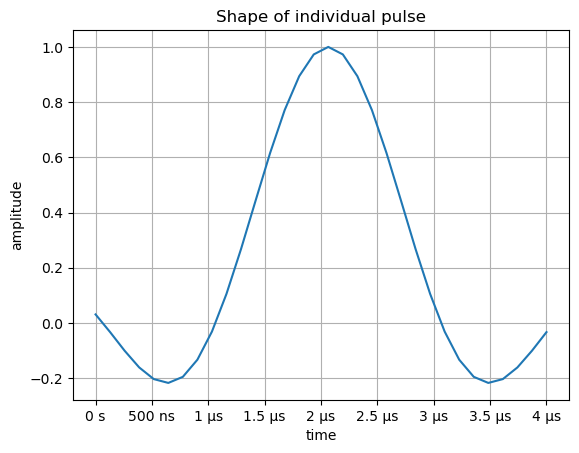

In [70]:
vsinc = np.sinc((bw_Hz)*(time-t_disp))

fig, ax = plt.subplots()
plt.plot(time,vsinc,label='SINC')
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlabel("time")
plt.ylabel("amplitude")
formatter0 = EngFormatter(unit='s') #formats units to eng notation
ax.xaxis.set_major_formatter(formatter0) #set formatter to plot
plt.grid()
plt.title("Shape of individual pulse")


### FFT Parameters 

**Important Note**: Depending on the number of samples chosen for the length of the impulse response, the FFTs plots may distort. That is because we do not have enough resolution into one single pulse to achieve the number of frequency components to have a good resolution of the impulse response in the frequency domain. Nevertheless, the plots can still be usefull to determine the bandlimited property of the pulses.

In [71]:
#parameters for FFT
count = len(vsinc)
values = np.arange(int(count/2))
time_period = count/f_sampling
frequencies = values/time_period

print("FFT PARAMETERS")
print("Length of sinal (must be the equals numPoints):")
print(count)
print("Sample of the frequency components:")
print(values[:10])
print("FFT time window length:")
print(Quantity(time_period,'s'))
print("Sample of the array of frequencies (Hz):")
print(frequencies[:10])
print("Length of frequencies array:")
print(len(frequencies))
print("Desired data-rate")
print(Quantity(Rb,'bps'))

FFT PARAMETERS
Length of sinal (must be the equals numPoints):
32
Sample of the frequency components:
[0 1 2 3 4 5 6 7 8 9]
FFT time window length:
4 us
Sample of the array of frequencies (Hz):
[      0.  250000.  500000.  750000. 1000000. 1250000. 1500000. 1750000.
 2000000. 2250000.]
Length of frequencies array:
16
Desired data-rate
1 Mbps


### FFT Plot of sinc pulse

* We can observe the Gibb's Phenomenon due to the window truncation of the sinc pulse;
* It appears as a ripple effect in the spectrum of the pulse;
* This can be mitigated with a root-raised cosine pulse, which will be shown next.

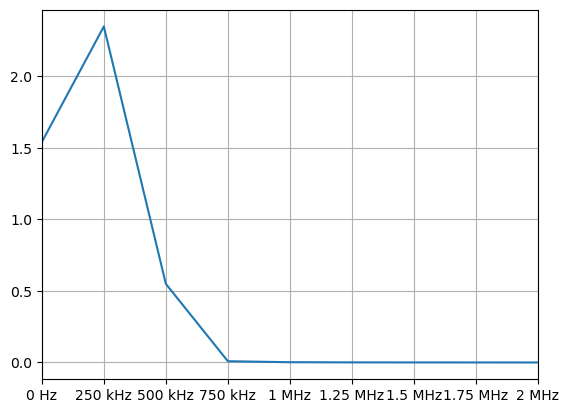

In [72]:
vsinc_fft = np.fft.fft(vsinc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
frequencies = np.fft.fftfreq(vsinc.size,1/f_sampling) #gets the vector of positive frequencies

fig, ax = plt.subplots()
plt.plot(frequencies[:int(frequencies.size/2)],abs(vsinc_fft[:int(frequencies.size/2)])**2,label = "SINC") #plots power spectrum
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlim([0,2*bw_Hz]) #defines frequency limit
plt.grid()
formatter0 = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter0)

### Raised cosine pulse (RRC)

The RRC pulse $h(t)$ is a sinc filter multiplied by an attenuation factor in the form:

$ h(t) = Rb \times sinc(Bt) \dfrac{\cos(\pi t r B)}{1 - 4 r^2 t^2 B^2}$

Where:
* $r$ is the roll-of factor that controls the ripple of the spectrum lobe, also its rate of decay;
* $B$ is the bandwidth of the signal;
* $t$ is the time array;
* The roll-off factor is chosen so it attenuates the ripple effect in the spectrum. However, it also changes the effective bandwidth of the signal;
* The term $R_b$ multiplying the impulse response stands for the gain desired so the pulse may have a magnitude of 1 in its bandwidth.



### Comparision between pulses in time

GridSpec(1, 1)

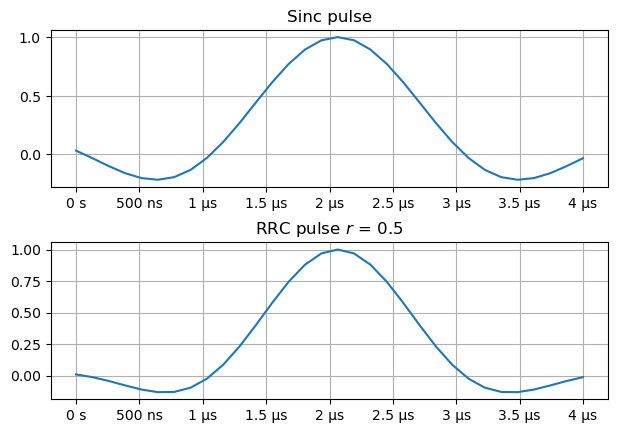

In [73]:
#roll-of factor 
r = 0.5
#rrc filter on time domain
h_rrc = vsinc * (np.cos(np.pi*(time-t_disp)*r*bw_Hz)) / (1 - 4 * r**2 * (time-t_disp)**2 * bw_Hz**2)

##ploting both filters
fig, axs = plt.subplots(2)
axs[0].plot(time,vsinc)
axs[0].set_title("Sinc pulse")
axs[0].grid()
axs[1].plot(time,h_rrc)
axs[1].set_title("RRC pulse $r$ = {}".format(r))
axs[1].grid()
axs[0].set_label("time (s)")
axs[1].set_label("time (s)")
#adjust xlabel ticks for Eng Formatter in seconds
formatter0 = EngFormatter(unit='s')
axs[0].xaxis.set_major_formatter(formatter0)
axs[1].xaxis.set_major_formatter(formatter0)
# shift subplots down to adjust titles
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.add_gridspec()


### FFT of RRC pulse


* The next plot shows the RCC pulse spectrum along with the desired bandwidth of the signal.

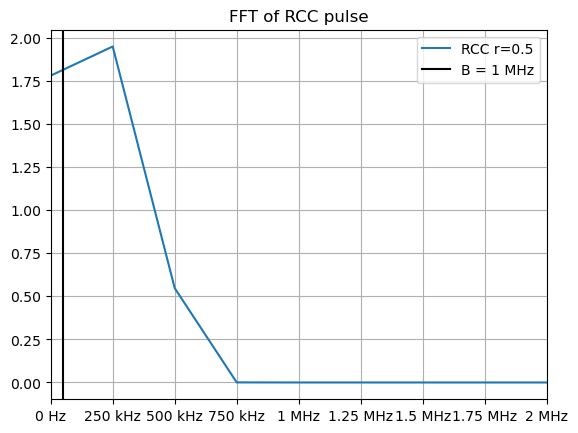

In [74]:
h_rrc_fft = np.fft.fft(h_rrc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
frequencies = np.fft.fftfreq(h_rrc.size,1/f_sampling) #gets the vector of positive frequencies

fig, ax = plt.subplots()
plt.plot(frequencies[:int(frequencies.size/2)],abs(h_rrc_fft[:int(frequencies.size/2)])**2, label = "RCC r={}".format(r)) #plots power spectrum
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlim([0,2*bw_Hz]) #defines frequency limit
plt.axvline(x=50e3, color='k',label='B = {}'.format(Quantity(bw_Hz,'Hz'))) #adds a dark horizontal line to mark the bandwidth
plt.grid()
plt.legend()
plt.title("FFT of RCC pulse")
formatter0 = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter0)

### Comparison between spectrums

* We can see the RCC pulse operating on the ripple effect of the spectrum, in exchange of effective bandwidth of the signal.

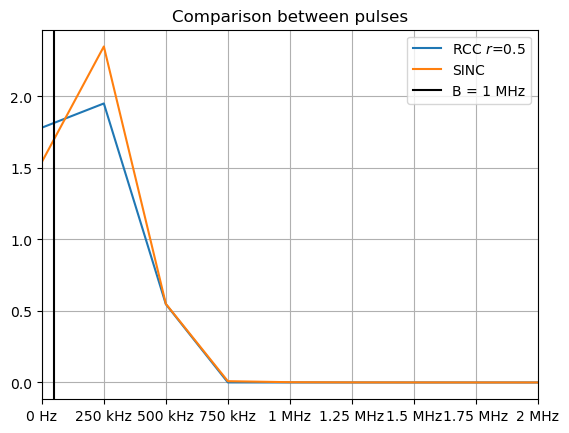

In [75]:
fig, ax = plt.subplots()
plt.plot(frequencies[:int(frequencies.size/2)],abs(h_rrc_fft[:int(frequencies.size/2)])**2,label = "RCC $r$={}".format(r)) #power spectrum rcc pulse
plt.plot(frequencies[:int(frequencies.size/2)],abs(vsinc_fft[:int(frequencies.size/2)])**2,label = "SINC") #power spectrum sinc pulse
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlim([0,2*bw_Hz]) #defines frequency limit
plt.axvline(x=50e3, color='k',label='B = {}'.format(Quantity(bw_Hz,'Hz'))) #adds a dark horizontal line to mark the bandwidth
plt.grid() #grid on
plt.title("Comparison between pulses")
plt.legend()
formatter0 = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter0)

### Comparison between roll-off factors

The next plot shows the differences in the spectrum of the RCC pulse for some different values of $r$

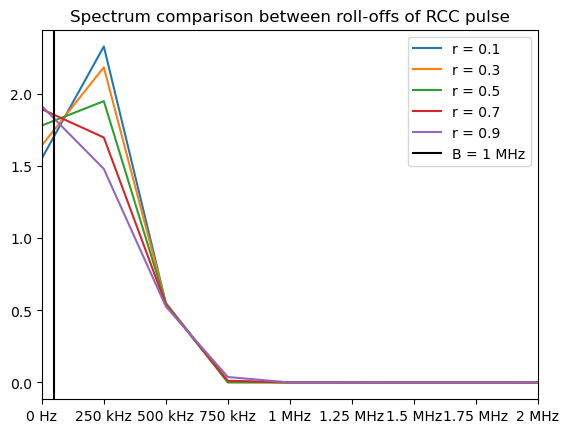

In [76]:
roll_off_factors = [0.1,0.3,0.5,0.7,0.9]
fig, ax = plt.subplots()
for r in roll_off_factors:
    h_rrc = vsinc * (np.cos(np.pi*(time-t_disp)*r*bw_Hz)) / (1 - 4 * r**2 * (time-t_disp)**2 * bw_Hz**2)
    h_rrc_fft = np.fft.fft(h_rrc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
    frequencies = np.fft.fftfreq(h_rrc.size,1/f_sampling) #gets the vector of positive frequencies
    plt.plot(frequencies[:int(frequencies.size/2)],abs(h_rrc_fft[:int(frequencies.size/2)])**2, label = "r = {}".format(r)) #plots power spectrum
r=0.5
plt.xlim([0,2*bw_Hz]) #defines frequency limit
plt.title("Spectrum comparison between roll-offs of RCC pulse")
plt.axvline(x=50e3, color='k',label='B = {}'.format(Quantity(bw_Hz,'Hz'))) #adds a dark horizontal line to mark the bandwidth
formatter0 = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter0)
plt.legend()


**Partial conclusions on the roll-off factor:**
* $r = 0.3$ shows a good attenuation wile mantainig a minor bandwidth reduction (about 70% of desired bandwidth on naked eye observation);

### Plot of Spectra in log base

* The following code and plots show a comparision between the sinc and rcc pulses in a log base 

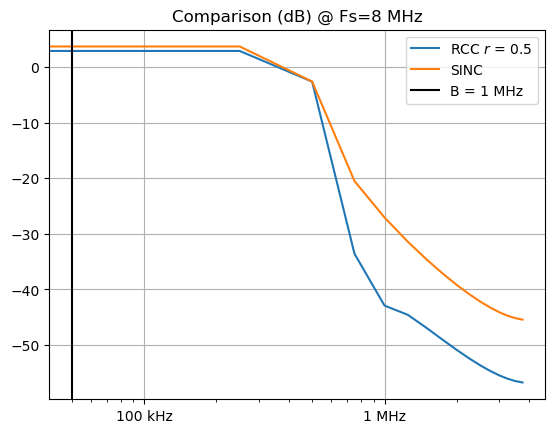

In [77]:
#rrc filter in time domain now with roll-of = 0.3
h_rrc= vsinc * (np.cos(np.pi*(time-t_disp)*r*bw_Hz)) / (1 - 4 * r**2 * (time-t_disp)**2 * bw_Hz**2) 
vsinc_fft = np.fft.fft(vsinc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
h_rrc_fft = np.fft.fft(h_rrc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
#compute log scale in dB
h_rcc_logscale = 20*np.log10(abs(h_rrc_fft))
vsinc_logscale = 20*np.log10(abs(vsinc_fft))

'''
# visualization of log magnitude data stream
print("Sample Visualization of log magnitude of RCC:")
print(h_rcc_logscale[0:10])
print("Sample Visualization of log magnitude of SINC:")
print(vsinc_logscale[0:10])
'''

#Plot frequency logscale of magnitude in dB 
fig, ax = plt.subplots()
plt.plot(frequencies[:int(frequencies.size/2)],h_rcc_logscale[:int(frequencies.size/2)],label = "RCC $r$ = {}".format(r)) #power spectrum rcc pulse
plt.plot(frequencies[:int(frequencies.size/2)],vsinc_logscale[:int(frequencies.size/2)],label = "SINC") #power spectrum sinc pulse
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
#plt.xlim([0,2*bw_Hz]) #defines frequency limit
plt.grid() #grid on
plt.title("Comparison (dB) @ Fs={}".format(Quantity(f_sampling,'Hz')))
ax.set_xscale("log")
formatter0 = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter0)
plt.axvline(x=50e3, color='k',label='B = {}'.format(Quantity(bw_Hz,'Hz'))) #adds a dark horizontal line to mark the bandwidth
plt.legend()

## Transmitting a pulse sequence over distortionless channel


* The next sections showed how to develop a Sinc pulse, a Nyquist pulse, and a more usable pulse, called the RCC pulse; 
* This sectin shows to properly build a message signal by utilizing both pulses;

### Important Note On Pulse Shaping

When dealing with pulse shaping in real problems, Lathi [1] states that "should be remembered that it is the pulses received at the detector input that should have the Nyquist form". In other words, after passing through a non-ideal channel, the channel distortion must be compensated, so the receiver may see the desired raised cosine pulse.

Therefore, if the pulse is passing through a channel with a transfer function of $H_c(f)$, the transmitted pulse $P_i(f)$ should satisfy the equation:

$P_i(f)H_c(f) = P(f)$.

Where $P(f)$ is the raised cosine impulse response.

Hence, the "actual" impulse pulse response to be transmitted must be of the form

$P_i(f) = P(f)/H_c(f)$.

Oftentimes this process of estimating the channel's transfer function and compensating into the transmitted pulse is called "pre-emphasis", where a digital gain is applied to the shape of the pulse to compensate for the distortion of the channel.

### Generating Polar Bit Stream

* This section shows how to generate a bit stream, and how to visualize the bit distributions using a pandas frame;
* The final result is an int array containing a dummy vector of 0s and 1s to represent the bit stream;
* in polar signaling, bit 1 is transmitted by a pulse $p(t)$, while bit 0 is transmitted by a pulse $-p(t)$;
* The first to do is to generate an impulse train of 1s and -1s at the pulse's sampling frequency.

In [78]:
import pandas as pd
#Generate random bit sequence
numBits = 1000 #number of bits desired to transmit
noise = np.random.normal(0,1,numBits) #generates random noise
df = pd.DataFrame(np.sign(noise),columns=['polar']) #assigns a pandas dataframe of boolean type
polar = df[['polar']].to_numpy() #gets the array data
df.head() #displays the dataframe for visualization


,polar
0,-1.0
1,-1.0
2,1.0
3,1.0
4,-1.0


Text(0.5, 1.0, 'Symbol distribution of 1000 bit stream')

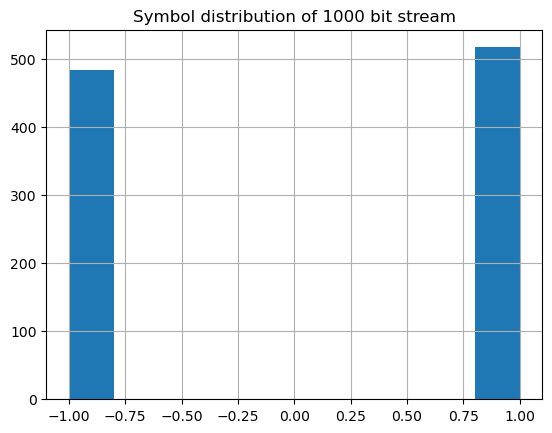

In [79]:
#Check if bitstream contains a regular distribution of bits 1s and 0s in polar form
df.hist()
plt.title("Symbol distribution of {}".format(numBits) + " bit stream")

In [80]:
#upsampling to get pulse train of line code
impulse_train = np.zeros(k*numBits) #assigns memory to pulse train
bit_index = 0 #tracks the bit index
for bits in polar:
    for j in np.zeros(k):
        impulse_train[bit_index*k] = bits
        impulse_train[bit_index*numBits:(k)] = j
    bit_index = bit_index + 1    
#definetely not the best solution... but works and I'm in a hurry
del bit_index #eliminates dummy variable for track bit index
df.head() #displays the dataframe for visualization
print("Length of impulse train")
print(len(impulse_train))

Length of impulse train
8000


In [81]:
#delay of the filter
filter_delay = len(h_rrc) #delay of the filter
#Bits lots per delay
bits_lost_delay = round(filter_delay*t_step/(1/Rb))
print("Filter delay in s:")
print(Quantity(filter_delay*t_step,'s'))

Filter delay in s:
4 us


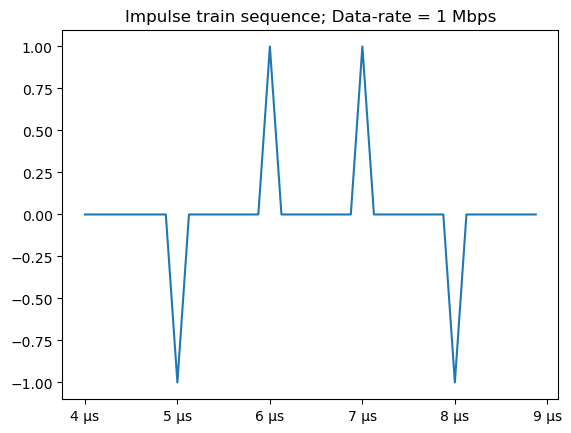

In [82]:
#plot the first impulses for eye verification
fig, ax = plt.subplots()
#time_pulse = np.linspace(filter_delay*t_step,k*numBits*t_step,k*(numBits-oversamp))
time_pulse = np.linspace(filter_delay*t_step,k*numBits*t_step,k*(numBits-oversamp))
plt.plot(time_pulse[:k*5],impulse_train[:k*5])
plt.title("Impulse train sequence; Data-rate = {}".format(Quantity(Rb,'bps')))
formatter0 = EngFormatter(unit='s')
ax.xaxis.set_major_formatter(formatter0)

In [83]:
#generating rectangular pulse for comparison
rect = np.ones(k) #rectangular pulse
#time pulse array
#pulse train with different pulses
pulse_train_rect = np.convolve(impulse_train,rect)
pulse_train_rcc = np.convolve(impulse_train,h_rrc)
#pulse_train_rect = pulse_train_rect[k:]
#pulse_train_rcc = pulse_train_rcc[oversamp*k:]
#print lengths
print(len(pulse_train_rect))
print(len(pulse_train_rcc))


8007
8031


In [84]:
#display lengths for checking
bitsToPlot = 500
print(len(impulse_train))
print(len(pulse_train_rect))
print(len(pulse_train_rcc))
print("Lengths for plotting")
print(len(time_pulse[:(bitsToPlot+oversamp)*k]))
print(len(pulse_train_rect[:(bitsToPlot+oversamp)*k]))
print(len(pulse_train_rcc[:(bitsToPlot+oversamp)*k]))
print("Bits to print:")
print(numBits)

8000
8007
8031
Lengths for plotting
4032
4032
4032
Bits to print:
1000


In [85]:
#Signal shift
#It has to do with the time displacement of the pulse
shift = round(numPoints/2) #This line shifts the pulse to the beginning of the impulse train
print("Time displacement of filter in samples:")
print(shift)

Time displacement of filter in samples:
16


In [86]:

pulse_train_rccp = np.roll(pulse_train_rcc[:(bitsToPlot)*k],-shift);
#pulse_train_rccp = np.roll(pulse_train_rcc[:(bitsToPlot)*k],round(-round(numPoints/2)*k));
print(3.5*k)
print(filter_delay)
print(k*oversamp)
print(numPoints/2)

28.0
32
32
16.0


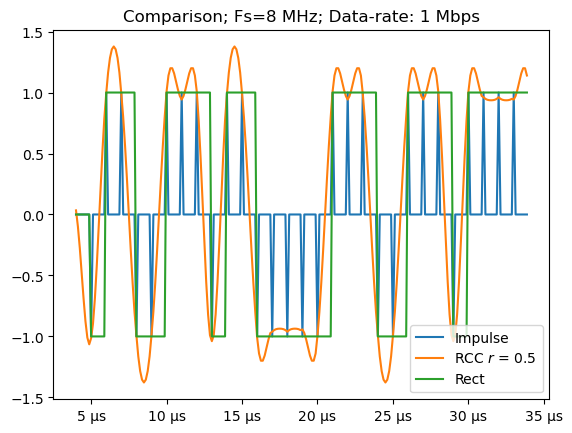

In [92]:
#plot of signals with fixed delay of the filter
bitsToPlot = 30
fig, ax = plt.subplots()
plt.plot(time_pulse[:(bitsToPlot)*k],impulse_train[:(bitsToPlot)*k],label = "Impulse")
plt.plot(time_pulse[:(bitsToPlot)*k],pulse_train_rccp[:(bitsToPlot)*k],label = "RCC $r$ = {}".format(r))
plt.plot(time_pulse[:(bitsToPlot)*k],pulse_train_rect[:(bitsToPlot)*k],label="Rect")
#plt.plot(time_pulse[1:5*numPoints],pulse_train_sine[1:5*numPoints],label="Sine")
formatter0 = EngFormatter(unit='s')
ax.xaxis.set_major_formatter(formatter0)
plt.title("Comparison; Fs={}".format(Quantity(f_sampling,'Hz'))+"; Data-rate: {}".format(Quantity(Rb,'bps')))
plt.legend()

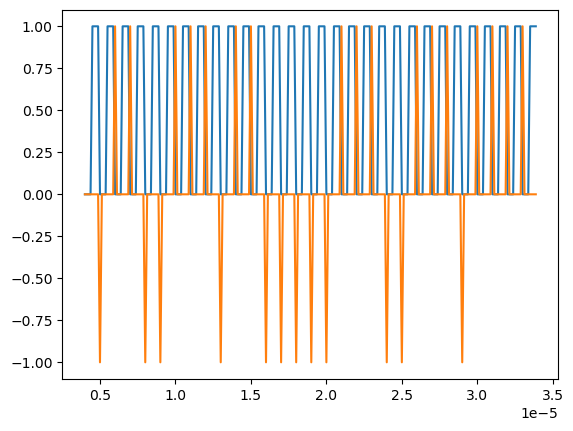

In [88]:
#Square wave (clock signal at the impulse train frequency)
from scipy import signal
bitsToPlot = 30
wt = 2*np.pi*time_pulse/(k*t_step)
square_wave = signal.square(t=wt,duty=0.5)
square_wave = (-1*square_wave +1)/2
plt.plot(time_pulse[:(bitsToPlot)*k],square_wave[:(bitsToPlot)*k])
plt.plot(time_pulse[:(bitsToPlot)*k],impulse_train[:(bitsToPlot)*k],label = "Impulse")


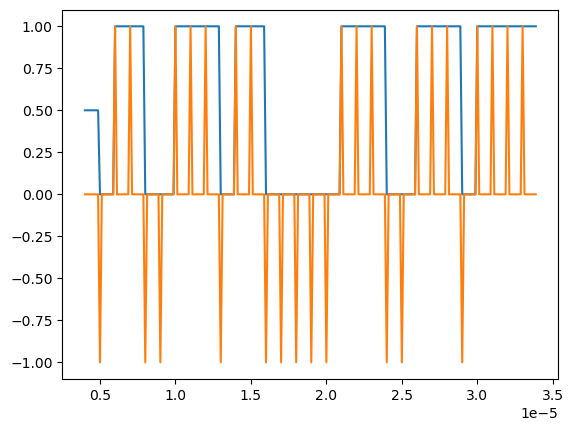

In [89]:
#On off wave

on_off_wave = (pulse_train_rect +1)/2
bitsToPlot =30
plt.plot(time_pulse[:(bitsToPlot)*k],on_off_wave[:(bitsToPlot)*k])
plt.plot(time_pulse[:(bitsToPlot)*k],impulse_train[:(bitsToPlot)*k],label = "Impulse")

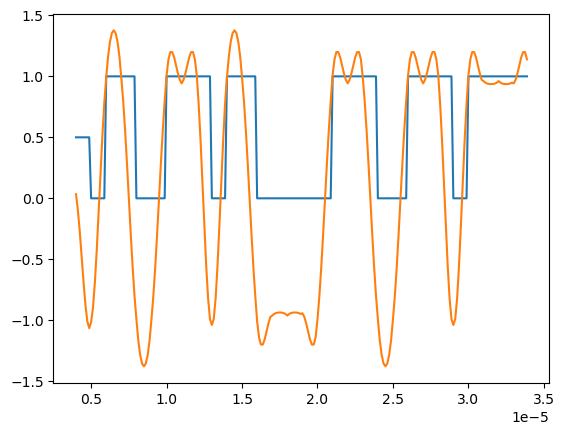

In [95]:
plt.plot(time_pulse[:(bitsToPlot)*k],on_off_wave[:(bitsToPlot)*k])
plt.plot(time_pulse[:(bitsToPlot)*k],pulse_train_rccp[:(bitsToPlot)*k],label = "RCC $r$ = {}".format(r))
#plt.plot(time_pulse[:(bitsToPlot)*k],pulse_train_rect[:(bitsToPlot)*k],label="Rect")



### Further Examples

* Link to future Welch Spectrum Plot of data
https://numpy.org/doc/stable/reference/generated/numpy.sinc.html


### References

[1] Lathi, B. P. *Principles of Digital and Analog Communications Systems*. LTC, 3rd ed. 1998

[2] https://www.mathworks.com/help/comm/ug/raised-cosine-filtering.html

[3] Gentile, K. *AN-922 Digital Pulse Shaping Basics*. [Available here](https://www.analog.com/media/en/technical-documentation/application-notes/an-922.pdf)

[4] McCune, E. *Practical Digital Wireless Signals*. Cambridge Press, 1st ed. 2010

##  Next steps: 
* Define a big bit-sequence and plot its Power Spectral Density;
* Create a Manchester Enconded symbol sequence;
* Apply the pulse-shaped sequence to LTSpice simulation;

## Generating Text Files

The code belows generates two text files to be used in the LTSpice simulation.

In [91]:
bitsToPlot = 200
np.savetxt('data_rcc.txt', np.transpose([time_pulse[:(bitsToPlot)*k],
            np.roll(pulse_train_rcc[:(bitsToPlot)*k],round(-3.5*k))]))
np.savetxt('data_rec.txt', np.transpose([time_pulse[:(bitsToPlot)*k],
            pulse_train_rect[:(bitsToPlot)*k]]))
np.savetxt('square_wave.txt', np.transpose([time_pulse[:(bitsToPlot)*k],
            square_wave[:(bitsToPlot)*k]]))
np.savetxt('on_off.txt', np.transpose([time_pulse[:(bitsToPlot)*k],
            on_off_wave[:(bitsToPlot)*k]]))
